In [3]:
import hyperiax


from hyperiax.tree.topology import read_topology, write_topology
from hyperiax.tree import HypTree
from hyperiax.plotting import plot_tree

from jax.random import PRNGKey, split
import jax
from jax import numpy as jnp
from hyperiax.execution import OrderedExecutor
from hyperiax.models import UpLambdaReducer, DownLambda, UpLambda
from hyperiax.models.functional import pass_up
from hyperiax.tree.topology import symmetric_topology, asymmetric_topology
from hyperiax.tree import HypTree
from hyperiax.plotting import plot_tree_text, plot_tree_2d_scatter
from matplotlib import pyplot as plt
import jax


# Rate likelihood estimation

This document is combined with the R simulations, and take the results the simulations from there and compare the results

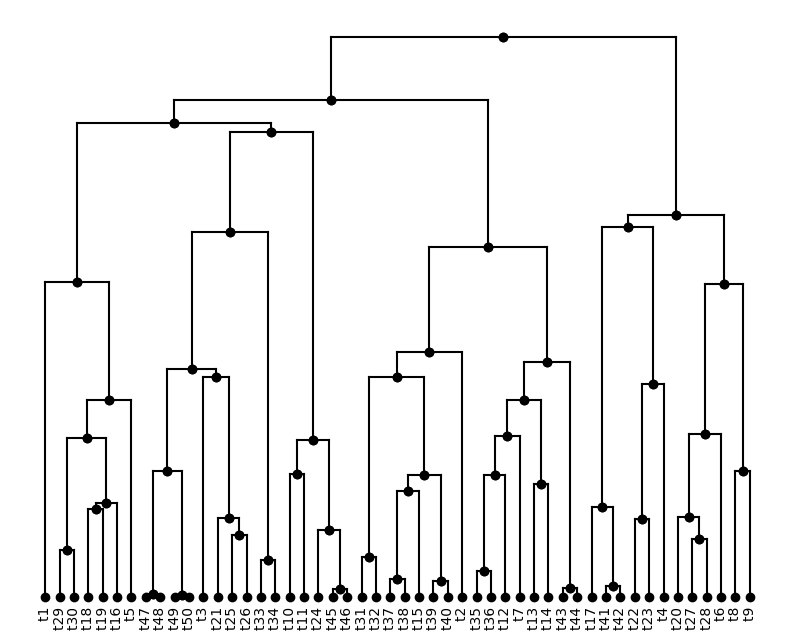

In [4]:
# Read tree, with edge lengths here

tree_string = open("./R/data-R/tree.tre", "r").read()
tree = read_topology(tree_string,return_topology=False,precompute_child_gathers=True)

plot_tree(tree,inc_names=True)


In [21]:
import pandas as pd
# Add the data to the tree
taxa = pd.read_csv("./R/data-R/character.txt", sep="\t", header=None)
print(taxa.head())

# Rearranged this, such that it is in the same order as the tree.data, which is based on a breath first search, 
# and not dfs as this order is. 


# Get node names from tree.iter_topology_leaves_bfs()
node_names = [node.name for node in tree.iter_topology_leaves_bfs()]


# order taxa according to node_names
taxa = taxa.set_index(0).loc[node_names].reset_index()

# Convert taxa values to one-hot encoding using numpy for efficiency
leaf_data = jnp.array([[1,0] if val == 1 else [0,1] for val in taxa[1]], dtype=jnp.int32)


# Define in hyperiax tree
tree.add_property('value', shape=(2,))
tree.data['value'] = tree.data['value'].at[tree.is_leaf].set(leaf_data)


tree.add_property('estimated_value', shape=(2,))
tree.data['estimated_value'] = tree.data['estimated_value'].at[tree.is_leaf].set(leaf_data)



tree.add_property('alpha', shape=(1,))
tree.add_property('beta', shape=(1,))



     0  1
0   t1  2
1  t29  2
2  t30  2
3  t18  1
4  t19  2


# Hyperiax implementaiton of the likelihood estimator


In [4]:
# Define rate matrix, which is 2x2 as a function of input of alpha and beta
# as a function 
Q_rate_matrix = lambda alpha, beta: jnp.array([[-alpha, alpha], [beta, -beta]])

prob_estimation = lambda character, length, alpha, beta: jnp.dot(character, jax.scipy.linalg.expm(Q_rate_matrix(alpha, beta) * length))

def probability_function(value,child_estimated_value, child_edge_length,leaf_mask, child_alpha, child_beta,**kwargs):
    # Assume all rows in child_params are identical
    alpha = child_alpha[0,0].astype(float)[0]  # Extract first value assuming they are the same
    beta = child_beta[0,0].astype(float)[0]  # Extract first value assuming they are the same

    # Use the prob_estimation function defined at module level and vectorize the operation
    probs = jax.vmap(lambda x, y: prob_estimation(x, y, alpha, beta),in_axes=0)(child_estimated_value, child_edge_length)

    
    # Compute the product along axis 1
    prods = jnp.prod(probs, axis=1)

    # Rescale the likelihood
    result = prods / jnp.sum(prods, axis=1, keepdims=True)

    # Mask padding
    result = jnp.where(leaf_mask[:, None], value, result)
    return {'estimated_value': result}




In [5]:


upmodel = UpLambda(up_fn=probability_function)
upmodelexe = OrderedExecutor(upmodel)
res = upmodelexe.up(tree)



In [9]:
pi_root = jnp.array([0.5,0.5])

def negative_log_likelihood(pred_root):
    return (jnp.log(jnp.sum(pi_root*pred_root)))


# Create grid of alpha and beta values
alphas = jnp.linspace(0.01, 0.99, 100)
betas = jnp.linspace(0.01, 0.99, 100)

# Initialize array to store results
results = jnp.zeros((len(alphas), len(betas)))
# Initialize array to store pred_root values
pred_roots = jnp.zeros((len(alphas), len(betas), 2))

# Calculate negative log likelihood for each combination
for i, alpha in enumerate(alphas):
    for j, beta in enumerate(betas):
        tree.data['alpha'] = tree.data['alpha'].at[:].set(jnp.array([alpha]))
        tree.data['beta'] = tree.data['beta'].at[:].set(jnp.array([beta]))

        res = upmodelexe.up(tree)

        pred_root = jnp.array(tree.data["estimated_value"][tree.is_root])[0]

        results = results.at[i,j].set(negative_log_likelihood(pred_root))
        pred_roots = pred_roots.at[i,j].set(pred_root)

# Print results
print("Negative log likelihood values for different alpha-beta combinations:")
#print(results)

# Find best parameters
min_idx = jnp.argmax(results)
best_i, best_j = min_idx // len(betas), min_idx % len(betas)
print(f"\nBest parameters:")
print(f"Alpha: {alphas[best_i]:.3f}")
print(f"Beta: {betas[best_j]:.3f}")
print(f"Negative log likelihood: {results[best_i, best_j]:.3f}")
print(f"Best pred_root: {pred_roots[best_i, best_j]}")


Negative log likelihood values for different alpha-beta combinations:

Best parameters:
Alpha: 0.030
Beta: 0.010
Negative log likelihood: -0.693
Best pred_root: [0.14529563 0.85470444]


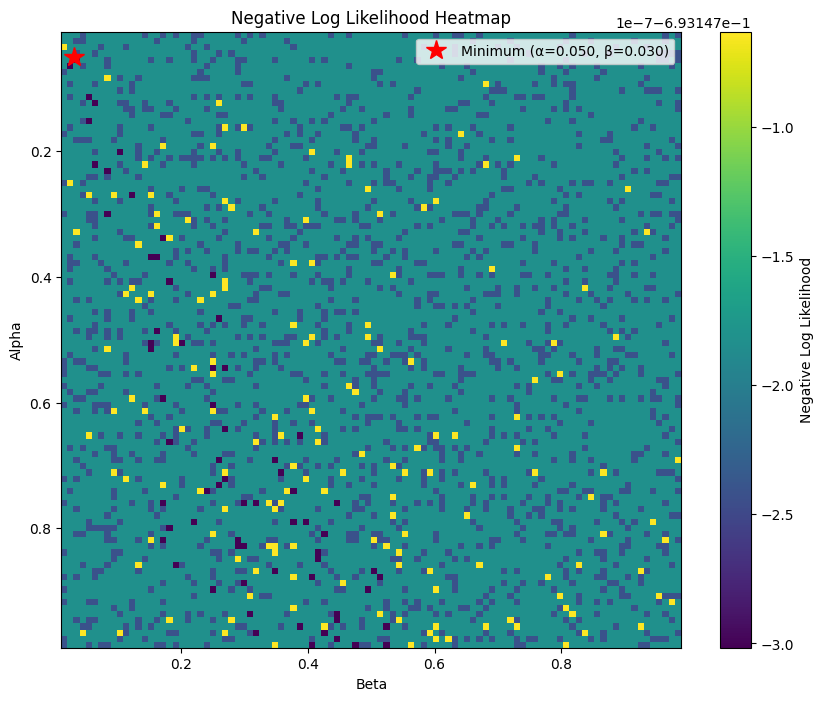

In [11]:
import matplotlib.pyplot as plt

# Create a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(results, cmap='viridis', aspect='auto',
           extent=[betas[0], betas[-1], alphas[-1], alphas[0]])  # Flip alpha axis
plt.colorbar(label='Negative Log Likelihood')

# Add labels and title
plt.xlabel('Beta')
plt.ylabel('Alpha') 
plt.title('Negative Log Likelihood Heatmap')

# Mark the minimum point
plt.plot(betas[best_j], alphas[best_i], 'r*', markersize=15,
         label=f'Minimum (α={alphas[best_i]:.3f}, β={betas[best_j]:.3f})')
plt.legend()

plt.show()